In [ ]:
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam
from gpytorch.optim import NGD

from alfi.models import generate_multioutput_rbf_gp
from alfi.plot import Plotter1d
from alfi.utilities.torch import softplus
from alfi.datasets import SingleCellKidney, Pancreas
from alfi.impl.trainers import EMTrainer
from alfi.impl.odes import RNAVelocityLFM, RNAVelocityConfiguration

import numpy as np

In [ ]:
# kidney_path = '/Volumes/ultra/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
# kidney_path = 'F:/genomics/scRNA-seq/GSE131685_RAW_kidney/velocyto'
#
# dataset = SingleCellKidney(calc_moments=True, raw_data_dir=kidney_path)
single_gene = True
cpe_index = 1710

if single_gene:
    dataset = Pancreas(data_dir='../../data', gene_index=cpe_index)
    cpe_index = 0
else:
    dataset = Pancreas(data_dir='../../data')
# cpe_index = np.where(dataset.loom.var.index == 'Cpe')[0][0]

In [18]:
def print_scatter(cells, gene_index, num_connections=10, figsize=(3, 3), colors=None):
    traj = lfm.current_trajectory
    u = traj[:num_genes].detach()  # (num_genes, 100)
    s = traj[num_genes:].detach()  # (num_genes, 100)
    u_y = cells[:num_genes]  # (num_genes, num_cells)
    s_y = cells[num_genes:]  # (num_genes, num_cells)
    print(u.shape)
    plt.figure(figsize=figsize)
    plt.title(dataset.gene_names[gene_index])

    # Plot trajectory
    plt.plot(s[gene_index], u[gene_index], color='red')

    # Plot cell points
    indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                             u_y[gene_index, :, 0].nonzero())
    plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], alpha=0.1,s=5, c='black')

    # Plot timepoint choices
    for timepoint in range(lfm.timepoint_choices.shape[0]):
        plt.scatter(s[gene_index, timepoint], u[gene_index, timepoint], s=4, c='black')

    # Plot some connections between cell points and the trajectory line
    for i in range(num_connections):
        plt.scatter(s_y[gene_index, i, 0], u_y[gene_index, i, 0], s=8, c='red')
        line = [
            (s[gene_index, lfm.time_assignments_indices[i]], s_y[gene_index, i, 0]),
            (u[gene_index, lfm.time_assignments_indices[i]], u_y[gene_index, i, 0])
        ]
        plt.plot(line[0], line[1], alpha=0.5, c='purple')
        # trainer.time_assignments_indices[i]
    plt.ylabel('unspliced')
    plt.xlabel('spliced')

In [62]:
num_cells = dataset[0].shape[1]
num_genes = 1 if single_gene else 2000
num_outputs = 2 * num_genes
num_latents = 1 if single_gene else 10
num_inducing = 10  # (I x m x 1)
end_t = 20
use_natural = False

config = RNAVelocityConfiguration(
    num_samples=30,
    num_cells=num_cells,
    end_pseudotime=end_t
)

print('Number of cells:', num_cells)
print('Number of latent GPs (# transcription rates):', num_latents)

step_size = 1e-1

inducing_points = torch.linspace(0, end_t, num_inducing).repeat(num_latents, 1).view(num_latents, num_inducing, 1)
t_predict = torch.linspace(0, end_t, 80, dtype=torch.float32)

gp_model = generate_multioutput_rbf_gp(num_latents, inducing_points,
                                       use_scale=False, initial_lengthscale=5,
                                       gp_kwargs=dict(natural=use_natural))

Number of cells: 3696
Number of latent GPs (# transcription rates): 1


In [43]:
# Training the GP model
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from torch.optim import Adam
like = MultitaskGaussianLikelihood(1)
mll = ExactMarginalLogLikelihood(like, gp_model)
optim = Adam(gp_model.parameters(), lr=0.1)
t = torch.linspace(0, end_t, 10)
y = torch.tensor([1., 1., 1., 1., 1., 0.1, 0.1, 0.1, 0.1, 0.1]).unsqueeze(-1)
for epoch in range(10):
    optim.zero_grad()
    out = gp_model(t)
    print(out.mean.shape, y.shape)
    loss = - mll(out, y)
    print(loss)
    loss.backward()
    optim.step()

torch.Size([10, 1]) torch.Size([10, 1])
tensor(13.1475, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(12.8116, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(12.3635, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(12.1323, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(11.8237, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(11.6314, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(11.5144, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(11.4207, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(11.2959, grad_fn=<NegBackward>)
torch.Size([10, 1]) torch.Size([10, 1])
tensor(11.2096, grad_fn=<NegBackward>)


tensor([[3.3720]])
tensor([[2.1246]])
torch.Size([1, 100])


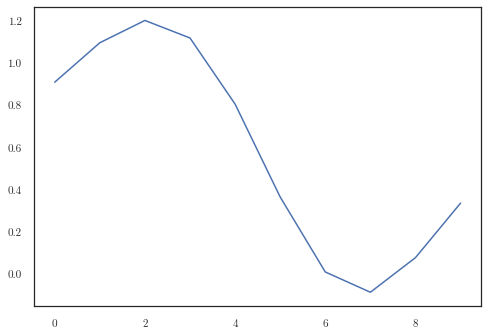

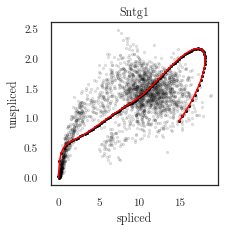

In [44]:
out = gp_model(t)
plt.plot(out.mean[:, 0].detach())
with torch.no_grad():
    lfm.raw_transcription_rate += 0.3
    print(lfm.splicing_rate)
    print(lfm.transcription_rate)
lfm(lfm.timepoint_choices, step_size=1e-1)
print_scatter(cells, cpe_index, num_connections=0)

In [63]:
data = dataset.m_observed.squeeze()
y_target = data
u_y = y_target[:num_genes]  # (num_genes, num_cells)
s_y = y_target[num_genes:]  # (num_genes, num_cells)
# w = torch.logical_and(u_y > 0, s_y > 0)
# u_y = torch.gather(u_y, dim=1, index=w)
print(s_y.shape)
x = s_y > torch.tensor(np.percentile(s_y, 98, axis=1)).unsqueeze(-1)
s = s_y * x
x = u_y > torch.tensor(np.percentile(u_y, 98, axis=1)).unsqueeze(-1)
u = u_y * x
s = s.unsqueeze(-1)
u = u.unsqueeze(1)
gamma = torch.matmul(u, s).squeeze(1).squeeze(1)
l2 = s.squeeze(2).square().sum(dim=1)
gamma /= l2
gamma = gamma.unsqueeze(-1)
if single_gene:
    gamma += 0.8

torch.Size([1, 3696])


In [64]:
data = dataset.m_observed
cells = data.permute(1, 2, 0)  # (O, C, 1)
u_y = cells[:num_genes]  # (num_genes, num_cells)
s_y = cells[num_genes:]  # (num_genes, num_cells)
nonzero_mask = list()
for gene_index in range(num_genes):
    nonzero_mask.append(torch.logical_and(s_y[gene_index, :, 0] > 0,
                                          u_y[gene_index, :, 0] > 0))
nonzero_mask = torch.stack(nonzero_mask).repeat(2, 1)

splicing_rate = torch.zeros_like(gamma)
splicing_rate += 1.4
transcription_rate = torch.zeros_like(gamma)
transcription_rate += 2.3
lfm_kwargs = dict(
    nonlinearity=softplus,
    decay_rate=gamma,
    splicing_rate=splicing_rate,
    transcription_rate=transcription_rate,
    num_training_points=num_cells,
    nonzero_mask=nonzero_mask
)
lfm = RNAVelocityLFM(num_outputs, gp_model, config, **lfm_kwargs)

if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_cells, lr=0.05)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.05)]
trainer = EMTrainer(lfm, optimizers, dataset, batch_size=4000)
plotter = Plotter1d(lfm, dataset.gene_names)

### Outputs prior to training:

<function softplus at 0x7f94fa5eaf80>
torch.Size([1, 100])
torch.Size([3696])


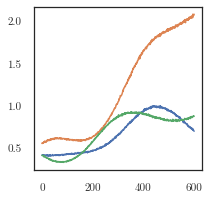

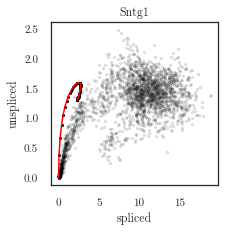

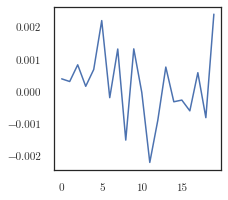

In [65]:
t = inducing_points
t_f = torch.arange(t.min(), t.max()+step_size/3, step_size/3)
num_samples = 3
s = lfm.sample_latents(t_f, num_samples)
print(lfm.nonlinearity)
plt.figure(figsize=(3, 3))
for i in range(num_latents):
    for sample in range(num_samples):
        plt.plot(s[sample, :, i].detach())

print_scatter(cells, cpe_index, num_connections=0)
plt.figure(figsize=(3, 3))
mean = list(lfm.gp_model.variational_parameters())[0]
plt.plot(mean.detach()[0])
print(lfm.time_assignments_indices.shape)

In [76]:
import time
start = time.time()

output = trainer.train(40, report_interval=5, step_size=1e-1)
end = time.time()
print(end - start)

num t2: torch.Size([93])
Epoch 151/190 - Loss: 1.32 (1.31 0.01) kernel: [6.1007943]
num t2: torch.Size([93])
num t2: torch.Size([93])
num t2: torch.Size([94])
num t2: torch.Size([94])
num t2: torch.Size([93])
Epoch 156/190 - Loss: 1.24 (1.23 0.01) kernel: [6.130661]
num t2: torch.Size([93])
num t2: torch.Size([93])
num t2: torch.Size([93])
num t2: torch.Size([94])
num t2: torch.Size([92])
Epoch 161/190 - Loss: 1.16 (1.16 0.01) kernel: [6.156476]
num t2: torch.Size([93])
num t2: torch.Size([92])
num t2: torch.Size([92])
num t2: torch.Size([94])
num t2: torch.Size([92])
Epoch 166/190 - Loss: 1.08 (1.08 0.01) kernel: [6.1811204]
num t2: torch.Size([92])
num t2: torch.Size([91])
num t2: torch.Size([93])
num t2: torch.Size([92])
num t2: torch.Size([93])
Epoch 171/190 - Loss: 1.00 (1.00 0.01) kernel: [6.2038207]
num t2: torch.Size([92])
num t2: torch.Size([92])
num t2: torch.Size([92])
num t2: torch.Size([91])
num t2: torch.Size([94])
Epoch 176/190 - Loss: 0.93 (0.92 0.01) kernel: [6.2247286

torch.Size([1, 100])


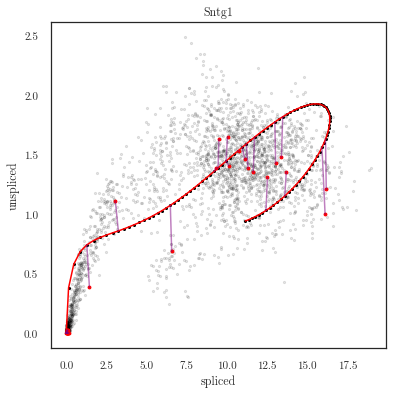

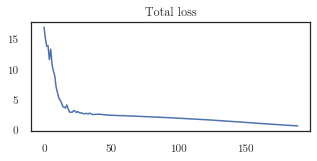

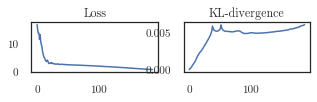

In [77]:
# plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=dataset.m_observed, model_kwargs=model_kwargs);
# plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

out = lfm(lfm.timepoint_choices, step_size=step_size)
end_index = 0 if single_gene else 2
for i in [cpe_index] + list(range(0, end_index)):
    print_scatter(cells, i, num_connections=30, figsize=(6, 6))

plotter.plot_losses(trainer, last_x=200)

In [9]:
savefile = './rna-1106'
do_save = False
if do_save:
    lfm.save(savefile)

do_load = False
if do_load:
    lfm = RNAVelocityLFM.load(savefile,
                              gp_model=gp_model,
                              lfm_args=[lfm.num_outputs, config],
                              lfm_kwargs=lfm_kwargs)


    optimizer = torch.optim.Adam(lfm.parameters(), lr=0.1)
    trainer = EMTrainer(lfm, [optimizer], dataset, batch_size=4000)
print(do_load)

False


In [139]:
#0, -3 15
#0 -2 0 3
out = lfm(lfm.timepoint_choices, step_size=step_size)
print(out.mean.shape)
out = out.mean.t().detach()
u_out = out[:num_genes].squeeze()
s_out = out[num_genes:].squeeze()
plt.plot(u_out[cpe_index, ::10])
plt.plot(-s_out[cpe_index, ::10] + 0.38)
# plt.plot(s_out[cpe_index, ::10], u_out[cpe_index, ::10])
# plt.plot(s_out[cpe_index, ::10])

torch.Size([3696, 2])


IndexError: too many indices for tensor of dimension 1

tensor(99)


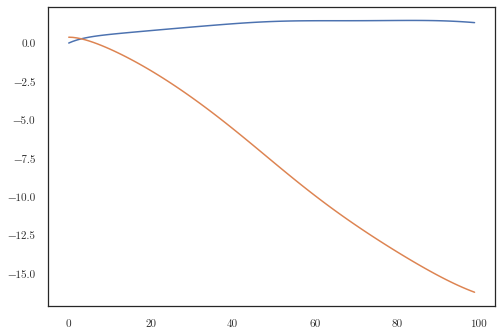

In [137]:
print(lfm.time_assignments_indices.max())
u_out = lfm.current_trajectory[:num_genes].detach()
s_out = lfm.current_trajectory[num_genes:].detach()
plt.plot(u_out[cpe_index])
plt.plot(-s_out[cpe_index] + 0.38)

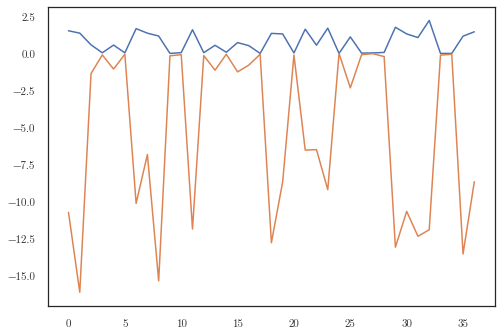

In [20]:
plt.plot(u_y[cpe_index, ::100])
plt.plot(-s_y[cpe_index, ::100])

# plt.scatter(s_y[cpe_index, ::10], u_y[cpe_index, ::10], alpha=0.1,s=5, c='black')

In [14]:
out = lfm(lfm.timepoint_choices, step_size=step_size)

In [76]:
mean = out.mean.t()
print(cells.shape, mean.shape)
# print(cells.squeeze()[0])
# print(cells.squeeze()[2000])
# print((cells.squeeze() * nonzero_mask)[2000].nonzero())
# with torch.no_grad():
    # lfm.splicing_rate[cpe_index] += 0.2
    # lfm.raw_decay_rate[cpe_index] += 0.5
print(lfm.decay_rate[cpe_index])
print(lfm.splicing_rate[cpe_index])
print(lfm.transcription_rate[cpe_index])

torch.Size([2, 3696, 1]) torch.Size([2, 3696])
tensor([0.1402], grad_fn=<SelectBackward>)
tensor([1.6715], grad_fn=<SelectBackward>)
tensor([1.4455], grad_fn=<SelectBackward>)


In [16]:
print(l2[cpe_index])
print(gamma.shape)
print(gamma.min())
print(gamma.max())
# s_low = s_y[s_sort_ind[-50:]]
# print(s_low)
# u_y.shape, s_y.shape

tensor(19980.4258)
torch.Size([2000, 1])
tensor(0.)
tensor(37.4716)


torch.Size([4000, 3696])
torch.Size([4000, 100])
torch.Size([100]) torch.Size([2000, 3696])


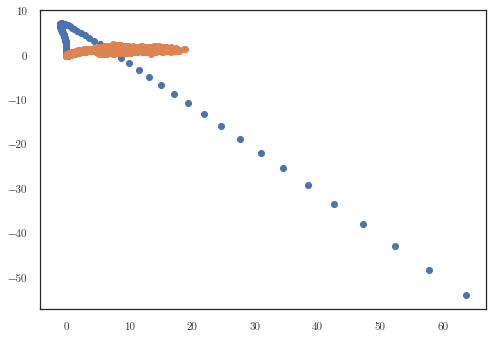

In [17]:
print(y_target.shape)
print(lfm.current_trajectory.shape)
u = lfm.current_trajectory[:2000].detach()[cpe_index]
s = lfm.current_trajectory[2000:].detach()[cpe_index]
u_y = y_target[:2000]  # (num_genes, num_cells)
s_y = y_target[2000:]  # (num_genes, num_cells)
print(u.shape, u_y.shape)
plt.scatter(s, u)
plt.scatter(s_y[cpe_index], u_y[cpe_index])

IndexError: too many indices for tensor of dimension 1

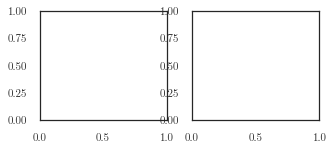

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 2))
axes[0].plot(u[:, cpe_index])
axes[1].plot(s[:, cpe_index])

### Outputs after training

In [ ]:
plotter.plot_losses(trainer, last_x=100)

for i in range(0, 50, 2):
    print_scatter(cells, i, num_connections=0)


torch.Size([2000, 3696, 1]) torch.Size([2000, 100, 1])
4000


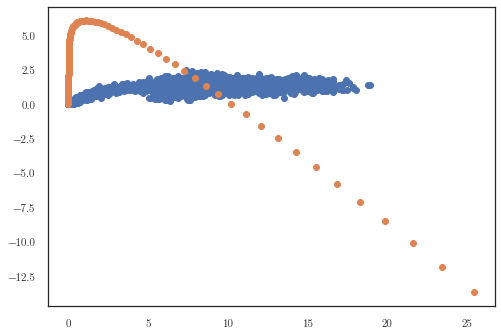

In [51]:
from alfi.utilities.torch import ceil
for i, data in enumerate(trainer.data_loader):
    y = data.permute(0, 2, 1)  # (O, C, 1)
batch_size = 500
num_batches = ceil(y.shape[1] / batch_size)
u_y = y[:num_outputs//2]  # (num_genes, num_cells)
s_y = y[num_outputs//2:]  # (num_genes, num_cells)
plt.scatter(s_y[cpe_index, :, 0], u_y[cpe_index, :, 0])
plt.scatter(s[cpe_index, :, 0], u[cpe_index, :, 0])
print(u_y.shape, s.shape)
print(num_batches * 500)
time_ass = torch.clone(lfm.time_assignments_indices)
for batch in range(num_batches):
    from_index = batch * batch_size
    to_index = (batch+1) * batch_size
    u_residual = u_y[:, from_index:to_index] - u.transpose(1, 2)
    s_residual = s_y[:, from_index:to_index] - s.transpose(1, 2)

    residual = u_residual.square() + s_residual.square()
    residual = residual.sum(dim=0).argmin(dim=1).type(torch.long)
    # print(residual.shape)
    # print(residual[:5])
    # print('done', batch)
    time_ass[from_index:to_index] = residual

torch.Size([4000, 3696, 1])
torch.Size([2000, 3696, 1]) torch.Size([2000, 1, 100])
torch.Size([500, 3696, 100])
1710
torch.Size([500, 3696, 100])
torch.Size([3696])
min torch.Size([500, 100])



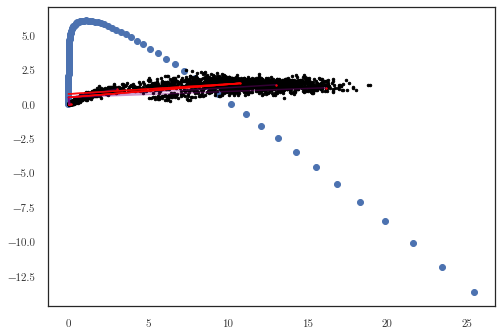

In [52]:
data = next(iter(trainer.data_loader))
y = data.permute(0, 2, 1)  # (O, C, 1)
print(y.shape)

traj = lfm.current_trajectory
u = traj[:2000].detach().unsqueeze(2)  # (num_genes, 100, 1)
s = traj[2000:].detach().unsqueeze(2)  # (num_genes, 100, 1)
u_y = y[:2000]  # (num_genes, num_cells)
s_y = y[2000:]  # (num_genes, num_cells)
u_y = cells[:2000]  # (num_genes, num_cells)
s_y = cells[2000:]  # (num_genes, num_cells)
print(s_y.shape, s.transpose(1, 2).shape)
u_residual = u_y[1500:] - u[1500:].transpose(1, 2)
s_residual = s_y[1500:] - s[1500:].transpose(1, 2)
print(u_residual.shape) # (genes, cells, timepoints)
residual = u_residual.square() + s_residual.square()
residual_indices = residual.sum(dim=0).argmin(dim=1).type(torch.long)
gene_index = cpe_index
print(gene_index)
print(residual.shape)
# residual_indices = residual.argmin(dim=1)
print(residual_indices.shape)
residual_minimum = residual.min(dim=1).values
print('min', residual_minimum.shape)
residual_sort_indices = residual_minimum.argsort(descending=True)
# print(residual_sort_indices)
# for this gene, the indices of the closest timepoint for all cells

# Plot trajectory
plt.scatter(s[gene_index], u[gene_index])

# Plot cell points
indices = np.intersect1d(s_y[gene_index, :, 0].nonzero(),
                         u_y[gene_index, :, 0].nonzero())
plt.scatter(s_y[gene_index, indices, 0], u_y[gene_index, indices, 0], s=6, c='black')
print()#torch.cat([
# for cell_index in residual_sort_indices[-900:]:#, residual_indices[torch.randperm(residual_indices.shape[0])[:1]]]):
for cell_index in range(10):
    plt.scatter(s_y[gene_index, cell_index, 0], u_y[gene_index, cell_index, 0], s=2, c='red')
    line = [
    (s[gene_index, residual_indices[cell_index]], s_y[gene_index, cell_index, 0]),
    (u[gene_index, residual_indices[cell_index]], u_y[gene_index, cell_index, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.4, c='purple')

    line = [
        (s[gene_index, time_ass[cell_index]], s_y[gene_index, i, 0]),
        (u[gene_index, time_ass[cell_index]], u_y[gene_index, i, 0])
    ]
    plt.plot(line[0], line[1], alpha=0.5, c='red')

# plt.xlim(0.015, 0.071)
# plt.ylim(0.22, 0.25)

In [ ]:
e
import scvelo as scv
scv.tl.velocity(dataset.loom)

In [ ]:
scv.pl.velocity(dataset.loom, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=2)

In [ ]:
velocity = dataset.loom.layers['velocity']
print(velocity[:100, cpe_index].shape)

In [20]:
adata = dataset.loom
_layers = adata[:, cpe_index].layers
u = _layers['Mu']
s = _layers['Ms']
